In [1]:
import numpy as np
import torch


import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.style.use('seaborn-colorblind')
from seaborn import kdeplot

## Leapfrog

In [2]:
def leapfrog(A, x0, v0, stepsize=1, n_steps=10):
    '''
    Solves ODE of the form (d^2 x)/(d t^2) = A(x)
    using leapfrog iterations (https://en.wikipedia.org/wiki/Leapfrog_integration, kick-drift-kick' form)

    Parameters:
    
    A : function
        Acceleration function R^p -> R^p. Takes position vector x and 
        returns acceleration: a = A(x).
    x0 : array
        Initial condition for position.
    v0 : array 
        Initial condition for velocity.
    stepsize : number
        Stepsize, default = 1.
    n_steps : int
        Number of steps, default = 10.
    '''
    dt = stepsize ## alias
    a0 = A(x0)
    v = v0 - a0 * dt/2 ## backward 1/2 step
    x = x0
    for i in range(n_steps):
        a = A(x)
        v = v + a * dt
        x = x + v * dt
        yield x, v + a * dt/2



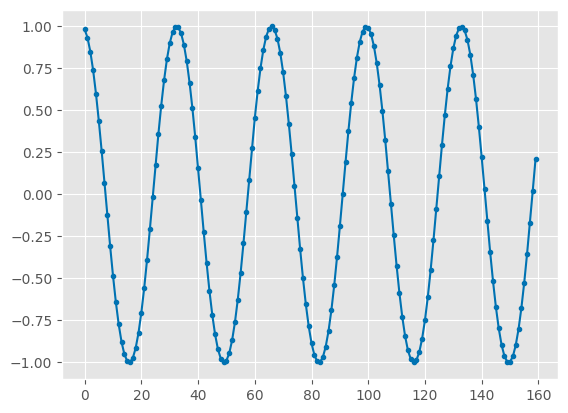

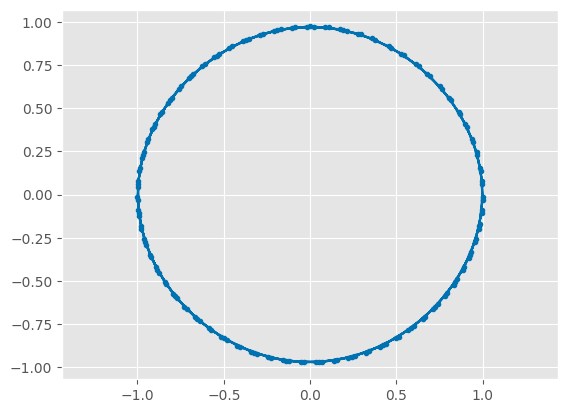

In [3]:
A = lambda x:-np.sin(x)
x0, v0 = 1, 0.0

states = leapfrog(A, x0, v0, stepsize=0.2, n_steps=160)

## Option 1: take the entire trajectory
states = np.array(list(states))
## Option 2: take only the final solution
*_, final = states


plt.plot(states[:,0], '.-')
plt.show()
plt.plot(states[:,0], states[:,1], '.-')
plt.axis('equal')
plt.show()

## Hamiltonian Monte Carlo (HMC)

In [166]:
def HMC(U, theta0, std=1, stepsize=0.01, n_steps=10, n_samples=10):
    '''
    Hamiltonian Monte Carlo
    
    Parameters:
    
    U : function
        Potential energy function U(theta:Tensor)  -> phi:Tensor. 
        Differentiable w.r.t theta, through U(theta).backward()
    theta0 : PyTorch tensor
        Initial condition
    std : number
        sqrt(mass), used as std of Gaussian
    stepsize : number
    n_steps : number
    n_samples : number
    '''
    
    def neg_dU(theta):
        '''negative gradient of dU through autodiff'''
        theta = theta.detach().requires_grad_(True)
        if theta.grad is not None:
            theta.grad.fill_(0)
        u = U(theta)
        u.backward()
        return -theta.grad
    def H(theta, r):
        '''Hamiltonian function'''
        return U(theta) + 1/2 * (r**2).sum()

    ## TODO: multivariable version
#     def neg_dU(*args):
#         '''negative gradient of dU through autodiff'''
#         args = [arg.detach().requires_grad_(True) for arg in args]
#         for arg in args:
#             if arg.grad is not None:
#                 arg.grad.fill_(0)
#         u = U(*args)
#         u.backward()
#         return [-arg.grad for arg in args]
    
#     def H(args, r):
#         '''Hamiltonian function'''
#         return U(*args) + 1/2 * (r**2).sum()
        
    theta = theta0
    for t in range(n_samples):
        rt = torch.randn(1) * std
        states = leapfrog(neg_dU, theta, rt, stepsize, n_steps)
        states = list(states)
        *_, proposal = states
        
        ## Metropolis-Hastings correction
        u = torch.rand(1)
        p = torch.exp(
            H(proposal[0], proposal[1]) 
            - H(theta, rt)
        )
        if u < min(1, p):
            ## accept
            theta = proposal[0]
            sample = proposal
        else:
            ## reject
            sample = [theta, rt]
            
        yield dict(
            acceptance = p,
            states = states,
            
            sample = sample
        )

In [291]:
%%time
# Hamiltonian Monte Carlo

U = lambda x: -torch.log(
    1 / np.sqrt(2*np.pi) * (
        1/3 * torch.exp(-x**2 / 2) 
        + 1/3 * torch.exp(-(x+4)**2 / 2) + 
        + 1/3 * torch.exp(-(x-4)**2 / 2)
    ) 
)
x0 = torch.tensor(0.01)

n_burnin = 100
n_samples = 1000
results = HMC(U, x0, std=1, stepsize=0.5, n_steps=20, n_samples = n_burnin + n_samples)
results = list(results)
samples = torch.tensor([r['sample'] for r in results])
states = torch.tensor([r['states'] for r in results])

CPU times: user 1min 21s, sys: 61.4 ms, total: 1min 21s
Wall time: 1min 21s


## Plot acceptance rate

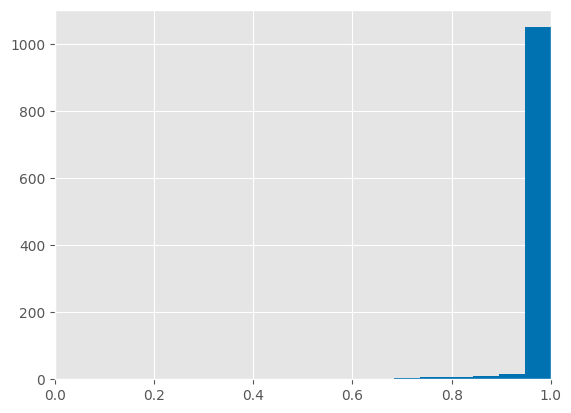

In [292]:
acceptance_rate = torch.tensor([r['acceptance'] for r in results])
acceptance_rate[acceptance_rate>1] = 1
plt.hist(acceptance_rate.numpy(), bins=np.linspace(0,1,20))
plt.xlim([0,1]);

## Prepare for plots

In [293]:
n_sample_plot = min(5000, states.shape[0])

xmin = samples[:,0].min()
xmax = samples[:,0].max()
ymax = samples[:,1].max()
x = torch.linspace(xmin, xmax, 100)
y = torch.exp(-U(x))

n_burnin, n_sample_plot

(100, 1100)

## Distribution

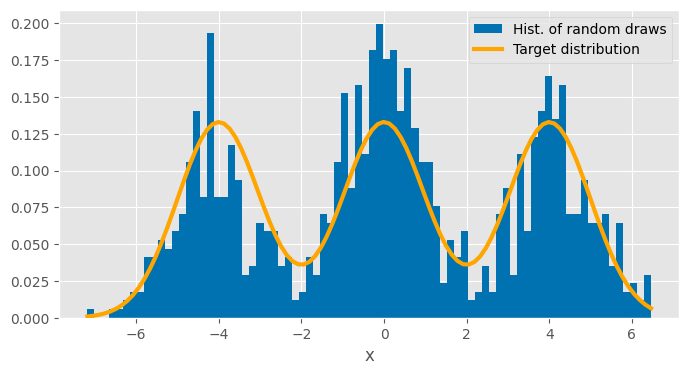

In [294]:
## Draw target probability and sample density
plt.figure(figsize=[8,4])
plt.hist(samples[n_burnin:,0].numpy(), bins=80, density=True, label='Hist. of random draws')
# kdeplot(samples[:,0].numpy(), linestyle='-', bw_adjust=0.3, label='Sample KDE')
plt.plot(x, y, color='orange', linestyle='-', zorder=3, lw=3, label='Target distribution')
plt.legend()
plt.xlabel('x')
plt.show()

## Hamiltonian paths

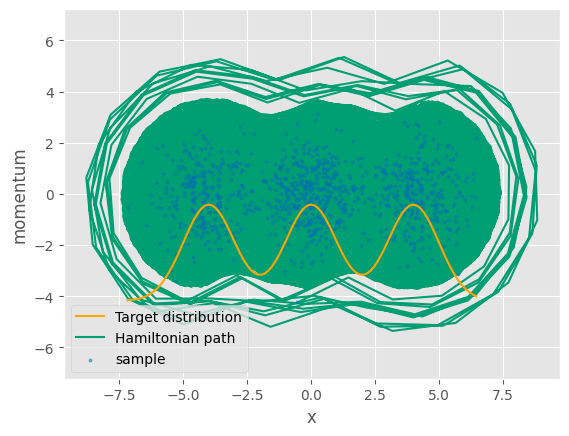

In [295]:

## plot
## 1. Draw target probability, whose neg log is defined as potential energy
plt.plot(x, y/y.max()*0.9*ymax-ymax, color='orange', zorder=3, label='Target distribution')

## 2. Draw state trajectories
## draw one curve with legend, draw the rest without
plt.plot(states[n_burnin,:,0], states[n_burnin,:,1], 'C1-', label='Hamiltonian path')
for i in range(n_burnin, n_sample_plot):
    plt.plot(states[i,:,0], states[i,:,1], 'C1-')
    
## 3. Draw final samples
plt.scatter(
    samples[n_burnin:n_sample_plot,0], 
    samples[n_burnin:n_sample_plot,1], 
    zorder=2, s=5, alpha=0.5, 
    label='sample')
plt.legend()
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('momentum')

plt.show()

In [7]:
# plt.plot(samples[:,0],samples[:,1], '.-')
# plt.scatter(samples[:,0],samples[:,1])
# plt.hist(samples[:,0].numpy(), bins=30);
